# Nonholonomic RRT 

by Emmy Chow

This theory of operation has consulted the following resources:

[RRT Implementation for Non-holonomic Robot (Part 2 - for car-like robots](https://www.linkedin.com/pulse/rrt-implementation-non-holonomic-robot-part-2-car-like-ankit-saini)

[Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/)

[RRT Path Planning using a Dynamic Vehicle Model](https://www.cs.cmu.edu/~motionplanning/reading/rosssiddpresentation.pdf)

In [232]:
import matplotlib.pyplot as plt
from mtree import MTree
from src.rrtutil import dist, dist2, diff
import numpy as np


class RRTNode(ndarray):
    def __new__(cls, arr: ArrayLike):
        n = asarray(arr).view(cls)
        return (n)

    # This is how you add properties to ndarray subclasses evidently.
    def __array_finalize__(self, obj):
        if obj is not None:
            # [phi, v, (start_t_idx, stop_t_idx), phi_idx]
            self.u = getattr(obj, 'u', [None] * 4)
            self.parent = getattr(obj, 'parent', None)

            # Deques have O(1) insertion at the end, no reallactions necessary!
            self.children = getattr(obj, 'children', deque())




def rotate(n, theta):
    """
    Equivalent to (but faster than)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    n[:2] = R @ n[:2]

    return(n)
    """

    c = np.cos(theta)
    s = np.sin(theta)
    
    n0 = n[0].copy()
    n1 = n[1].copy()

    n[0] = n0 * c - n1 * s
    n[1] = n0 * s + n1 * c

    return(n)

def plus_minus(gen):
    """
    Take a generator of and make it alternate in sign.
    
    [1, 2, 3] -> [1, -1, 2, -2, 3, -3]
    """
    for x in gen:
        yield (x)
        yield (-x)

In [385]:
from numpy import pi

L = 0.05
v_max = 5
T = 0.1  # Amount of time to simulate into the future

N_phi = 21  # Number of turning angles to generate
N_t = 10  # Resolution of Euler integration
N_v = 500

phi = np.linspace(-0.4 * np.pi, 0.4 * np.pi, N_phi)
primatives = np.zeros((N_t, N_v, N_phi, 3))
neg_prim = np.zeros_like(primatives)

primatives[0] = 0

dt = T / N_t

for i in range(N_v):
    v = i * v_max / N_v

    for j in range(1, N_t):
        primatives[j, i, :, 0] = (
            primatives[j - 1, i, :, 0] + 
            v * np.cos(phi) * np.cos(primatives[j - 1, i, :, 2] * pi) * dt
        )

        primatives[j, i, :, 1] = (
            primatives[j - 1, i, :, 1] + 
            v * np.cos(phi) * np.sin(primatives[j - 1, i, :, 2] * pi) * dt
        )

        primatives[j, i, :, 2] = (
            primatives[j - 1, i, :, 2] + 
            v / L * np.sin(phi) / (pi) * dt
        )

#primatives[..., 2] -= np.floor(primatives[..., 2])
neg_prim[..., :2] = -primatives[..., :2]
neg_prim[..., 2] = primatives[..., 2] + 1
        
candidates = primatives[-1]
neg_candidates = neg_prim[-1]

In [337]:
geom_prims = np.load("primatives.npy")
np.allclose(geom_prims[:N_t], primatives) and np.allclose(geom_prims[N_t:], neg_prim) 

True

In [370]:
prims = np.concatenate((primatives, neg_prim))

primative_tree = [MTree(dist) for i in range(500)]

for i in range(N_v):
    v = i * v_max / N_v
    for j in range(N_phi):
        n = RRTNode(primatives[-1, i, j])
        n.u[0] = phi[j]
        n.u[1] = v

        n.u[2] = primatives[:, i, j]
        n.u[3] = i

        primative_tree[i].add(n)

        n_neg = RRTNode(neg_prim[-1, i, j])
        n_neg.u[0] = phi[j]
        n_neg.u[1] = -v

        n_neg.u[2] = neg_prim[:, i, j]
        n_neg.u[3] = i

        primative_tree[i].add(n_neg)

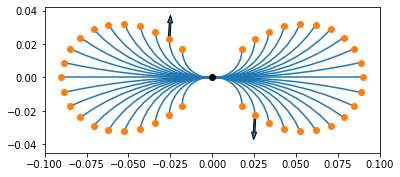

In [386]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.045, 0.042])

idx = 100

for i in range(primatives.shape[2]):
    ax.plot(primatives[:, idx, i, 0], primatives[:, idx, i, 1], 'C0')
    ax.plot(neg_prim[:, idx, i, 0], neg_prim[:, idx, i, 1], 'C0')

ax.plot(0, 0, 'ko')

ax.plot(candidates[idx, :, 0],  candidates[idx, :, 1], 'C1o')
ax.plot(neg_candidates[idx, :,  0],  neg_candidates[idx, :, 1], 'C1o')

c_idx = 1

dx = np.cos(candidates[idx, c_idx, 2] * pi) / 100
dy = np.sin(candidates[idx, c_idx, 2] * pi) / 100

ax.arrow(candidates[idx, c_idx, 0], candidates[idx, c_idx, 1], dx, dy)

dx = np.cos(neg_candidates[idx, c_idx, 2] * pi) / 100
dy = np.sin(neg_candidates[idx, c_idx, 2] * pi) / 100

ax.arrow(neg_candidates[idx, c_idx, 0], neg_candidates[idx, c_idx, 1], dx, dy)

plt.show()

In [373]:
p = np.array([0.6, 0.4, 0.1])
n = np.array([0.62, 0.45, 0.2])

x = rotate(diff(n, p), -p[2] * 2 * pi)
n_primative = primative_tree[idx].search(x)[0].obj  # nearest primative

print(x)
print(n_primative)

[0.0455696  0.02869514 0.1       ]
[0.08240092 0.01222198 0.10545992]


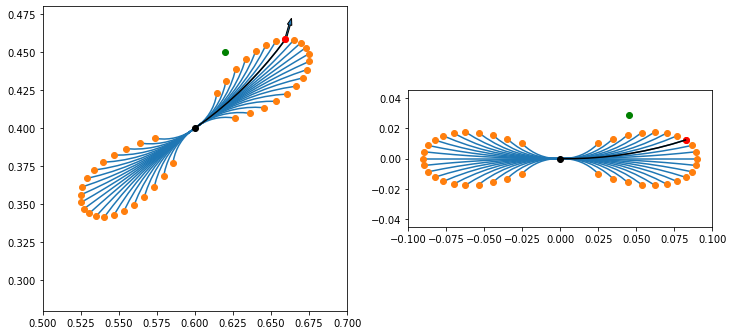

In [375]:
fig, ax = plt.subplots(1, 2, subplot_kw={'aspect': 'equal'}, figsize=(12, 9))

ax[0].set_xlim([-0.1 + p[0], 0.1 + p[0]])
ax[0].set_ylim([0.28, 0.48])

ax[1].set_xlim([-0.1, 0.1])
ax[1].set_ylim([-0.045, 0.045])

for i in range(primatives[:, idx].shape[1]):
    paths = rotate(primatives[:, idx, i, :2].T.copy(), 2 * pi * p[2]).T
    
    ax[0].plot(
        paths[:, 0] + p[0], 
        paths[:, 1] + p[1], 'C0'
    )
    
    ax[0].plot(
        -paths[:, 0] + p[0], 
        -paths[:, 1] + p[1], 'C0'
    )

ax[0].plot(p[0], p[1], 'ko')
ax[0].plot(n[0], n[1], 'go')

path_ends = rotate(candidates[idx, :, :2].T.copy(), 2 * pi * p[2]).T

ax[0].plot(
    path_ends[:, 0] + p[0],  
    path_ends[:, 1] + p[1], 
    'C1o'
)

ax[0].plot(
    -path_ends[:, 0] + p[0],  
    -path_ends[:, 1] + p[1], 
    'C1o'
)

for i in range(primatives[:, idx].shape[1]):
    ax[1].plot(primatives[:, idx, i, 0], primatives[:, idx, i, 1], 'C0')
    ax[1].plot(neg_prim[:, idx, i, 0], neg_prim[:, idx, i, 1], 'C0')

ax[1].plot(0, 0, 'ko')
ax[1].plot(candidates[idx, :, 0],  candidates[idx, :, 1], 'C1o')
ax[1].plot(neg_candidates[idx, :, 0],  neg_candidates[idx, :, 1], 'C1o')

ax[1].plot(x[0], x[1], 'go')
ax[1].plot(n_primative[0], n_primative[1], 'ro')

ax[1].plot(n_primative.u[2][:, 0], n_primative.u[2][:, 1], 'k')
curve = rotate_arc(n_primative.u[2][:, :2].copy(), p[2] * 2 * pi)
soln = rotate(n_primative.copy(), p[2] * 2 * pi)

ax[0].plot(curve[:, 0] + p[0], curve[:, 1] + p[1], 'k')
ax[0].plot(soln[0] + p[0], soln[1] + p[1], 'ro')

theta = soln[2] + p[2]

dx = np.cos(theta * 2 * pi) / 100
dy = np.sin(theta * 2 * pi) / 100

ax[0].arrow(soln[0] + p[0], soln[1] + p[1], dx, dy)

plt.show()